--- [Step 0: Installing and Importing Libraries] ---
Cloning into 'Amthal'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 1.47 MiB | 2.86 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Amthal/Amthal/Amthal
Libraries ready.

--- [Step 1: Loading Data] ---
Data loaded successfully. Found 4078 instances.

Calculating relative densities for Meccan and Medinan periods...
Generating the comparative bar chart...


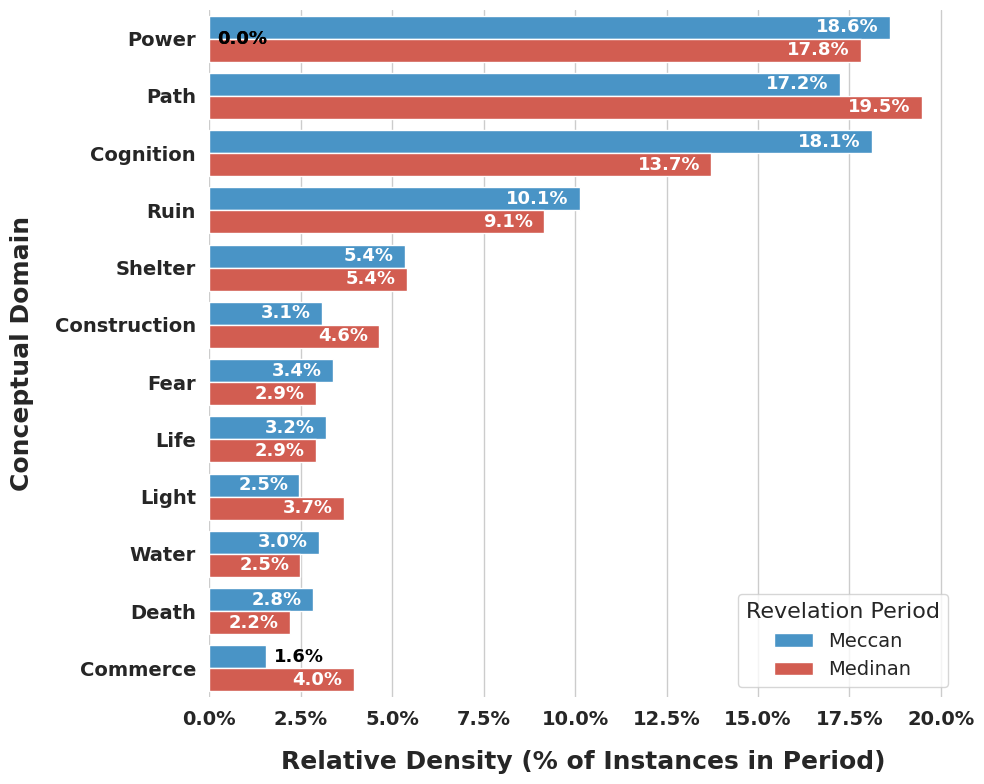

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title  **Comparative Density of Top 12 Conceptual Domains.**


# --- [الخطوة 0: التثبيت والاستيراد] ---
print("--- [Step 0: Installing and Importing Libraries] ---")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output

!apt-get -qq install -y graphviz libgraphviz-dev pkg-config
!pip install -qq pygraphviz seaborn matplotlib networkx pandas numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
import warnings
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout
warnings.simplefilter(action='ignore', category=FutureWarning)
print("Libraries ready.\n")


# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()



# --- 2. حساب الكثافات النسبية (نفس الكود الذي أنشأناه سابقًا) ---
print("Calculating relative densities for Meccan and Medinan periods...")

# الخطوة أ: حساب إجمالي المثيلات في كل فترة
phase_totals = df['Revelation_Phase'].value_counts()
total_meccan = phase_totals.get('مكي', 1) # استخدام 1 لتجنب القسمة على صفر إذا كانت فارغة
total_medinan = phase_totals.get('مدني', 1)

# الخطوة ب: حساب العد الخام لكل مفهوم في كل فترة
raw_counts = pd.crosstab(df['Dominant_Concept'], df['Revelation_Phase'])

# الخطوة ج: حساب الكثافة النسبية (التردد المئوي)
if 'مكي' in raw_counts.columns:
    raw_counts['Meccan_Density_%'] = (raw_counts['مكي'] / total_meccan) * 100
else:
    raw_counts['Meccan_Density_%'] = 0

if 'مدني' in raw_counts.columns:
    raw_counts['Medinan_Density_%'] = (raw_counts['مدني'] / total_medinan) * 100
else:
    raw_counts['Medinan_Density_%'] = 0

# الخطوة د: اختيار أهم 12 مفهومًا وتجهيز البيانات للرسم
# نحسب المجموع الكلي للفرز
raw_counts['Total_Count'] = raw_counts.get('مكي', 0) + raw_counts.get('مدني', 0)
top_12_concepts_df = raw_counts.nlargest(12, 'Total_Count')

# إعادة هيكلة DataFrame ليكون مناسبًا لـ seaborn (Long Format)
plot_data = top_12_concepts_df[['Meccan_Density_%', 'Medinan_Density_%']].reset_index()
plot_data = plot_data.melt(id_vars='Dominant_Concept',
                           var_name='Period',
                           value_name='Relative_Density_%')
# تنظيف أسماء الفترات
plot_data['Period'] = plot_data['Period'].replace({'Meccan_Density_%': 'Meccan', 'Medinan_Density_%': 'Medinan'})


# --- 3. إعداد الرسم البياني الاحترافي ---
print("Generating the comparative bar chart...")
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))

# إنشاء الرسم البياني بالأعمدة المجمعة (Grouped Bar Chart)
barplot = sns.barplot(
    data=plot_data,
    x='Relative_Density_%',
    y='Dominant_Concept',
    hue='Period', # هذا هو المفتاح لإنشاء أعمدة مجمعة
    palette={'Meccan': '#3498db', 'Medinan': '#e74c3c'}, # ألوان مميزة (أزرق وأحمر)
    ax=ax
)

# --- 4. إضافة التحسينات البصرية والتعليقات ---
ax.set_xlabel(
    'Relative Density (% of Instances in Period)',
    fontsize=18,            # حجم أكبر
    fontweight='bold',      # خط عريض
    labelpad=15
)
ax.set_ylabel(
    'Conceptual Domain',
    fontsize=18,
    fontweight='bold',
    labelpad=15
)

# تكبير الخطوط لعناوين القيم على المحورين
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# جعل النصوص على المحورين بخط عريض
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# إضافة علامة النسبة المئوية (%) إلى المحور السيني
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# --- إبقاء القيم المئوية على الأعمدة ---
for p in ax.patches:
    width = p.get_width()
    x_pos = width - (ax.get_xlim()[1] * 0.015) if width > ax.get_xlim()[1] * 0.1 else width + (ax.get_xlim()[1] * 0.01)
    ha = 'right' if width > ax.get_xlim()[1] * 0.1 else 'left'
    color = 'white' if width > ax.get_xlim()[1] * 0.1 else 'black'

    ax.text(
        x_pos,
        p.get_y() + p.get_height() / 2,
        f'{width:.1f}%',
        va='center',
        ha=ha,
        color=color,
        fontweight='bold',
        fontsize=13  # حجم النص فوق الأعمدة
    )

# تحسين الأسطورة (Legend)
ax.legend(
    title='Revelation Period',
    fontsize=14,
    title_fontsize=16,
    loc='lower right'
)

# إزالة الإطار
sns.despine(left=True, bottom=True)

# ضبط المسافات والعرض
plt.tight_layout()
plt.show()

# ضبط حجم علامات المحاور
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


# --- 5. الحفظ والعرض ---
plt.tight_layout()
plt.savefig('Figure_5a_Comparative_Density.png', dpi=300, bbox_inches='tight')
plt.show()